In [1]:
import os
from datetime import datetime, date
import calendar
import time
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from catboost import CatBoostRegressor, CatBoostClassifier, Pool, metrics, cv

from sklearn.metrics import recall_score, r2_score

%matplotlib inline

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
# df = pd.read_csv("data/train_dataset_train.csv", nrows = 10000)

df_train = pd.read_csv("data/train_dataset_train.csv")
# df_train = pd.read_csv("data/train_additional_dataset.csv")

# df_add = pd.read_csv("subway.csv")

df_test = pd.read_csv("data/test_dataset_test.csv")
# df_test = pd.read_csv("data/test_additional_dataset.csv")

In [3]:
df_test.ticket_type_nm.value_counts()

КОШЕЛЕК                                                   134786
30 дней ЕДИНЫЙ ТК                                          90977
Социальная карта москвича                                  65307
30 дней                                                    60807
90 дней ЕДИНЫЙ ТК                                          29938
30 дней СК студента                                        24952
60 поездок ЕДИНЫЙ ТК                                       23828
30 дней Пригород ТК                                        22854
СК студента 30 дней                                        20363
ББК                                                        15183
30 дней СК учащегося                                       12493
365 дней ЕДИНЫЙ ТК                                         11215
СК учащегося 30 дней                                        9099
Социальная карта жителя Моск. области                       7880
90 дней                                                     6519
Пропуск FacePay          

<AxesSubplot: >

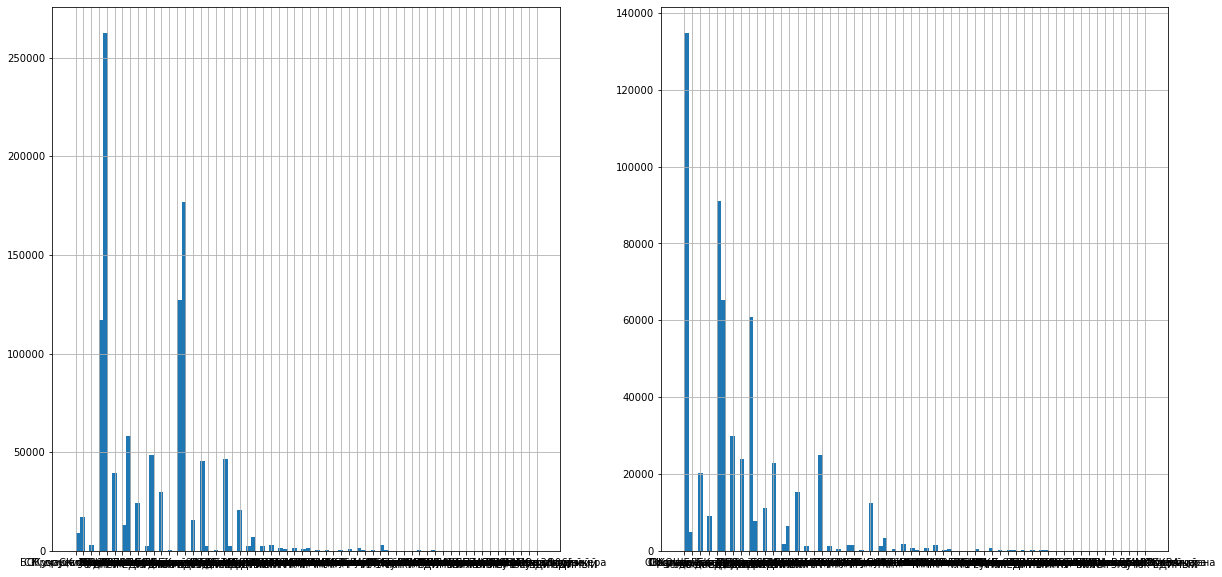

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df_train.ticket_type_nm.hist(bins=100, ax=ax[0])
df_test.ticket_type_nm.hist(bins=100, ax=ax[1])

In [5]:
df_train.ticket_type_nm.value_counts()

КОШЕЛЕК                                                   262499
30 дней ЕДИНЫЙ ТК                                         177041
Социальная карта москвича                                 127022
30 дней                                                   117064
90 дней ЕДИНЫЙ ТК                                          58071
30 дней СК студента                                        48658
60 поездок ЕДИНЫЙ ТК                                       46542
30 дней Пригород ТК                                        45381
СК студента 30 дней                                        39395
ББК                                                        29674
30 дней СК учащегося                                       24307
365 дней ЕДИНЫЙ ТК                                         20859
СК учащегося 30 дней                                       16933
Социальная карта жителя Моск. области                      15551
90 дней                                                    12817
Пропуск FacePay          

In [6]:
df1 = df_train.ticket_type_nm.unique()
df1.tolist()
# df["day_of_week"].astype('category').cat.codes
# df["day_of_week"] = df["day_of_week"].cat.codes

['Пропуск FacePay',
 'СК учащегося 30 дней',
 'БСК дружинника г.Москвы',
 '30 дней',
 'КОШЕЛЕК',
 'СК студента 30 дней',
 '90 дней',
 '90 дней ЕДИНЫЙ ТК',
 '30 дней СК учащегося',
 '90 дней СК студента',
 '30 дней СК студента',
 'ББК',
 'СК аспиранта 90 дней',
 'Социальная карта москвича',
 '30 дней ЕДИНЫЙ ТК',
 'Социальная карта жителя Моск. области',
 '30 дней Пригород ТК',
 'Социальная карта москвича с сопровождающим',
 'Пропуск сотрудника УВД по охране Метрополитена',
 '60 поездок ЕДИНЫЙ ТК',
 'СК для сотрудника ГУВД г.Москвы',
 '365 дней ЕДИНЫЙ ТК',
 'ВЕСБ МОСКВА (7мин)',
 'СК студента 90 дней',
 '90 дней Пригород ТК',
 '30 дней  Пригород',
 '365 дней Пригород ТК',
 '365 дней',
 'СК ординатора 30 дней',
 '30 дней СК аспиранта',
 '30 дней СК ординатора',
 '90 дней СК ординатора',
 'ВЕСБ МО (7 мин)',
 'ВЕСБ МО (тип 5)',
 'СК ординатора 90 дней',
 'СК аспиранта 30 дней',
 '90 дней СК учащегося',
 'Временный билет ММ',
 'Социальная карта жителя Моск. области с сопровождающим',
 'СК уч

In [7]:
df2 = df_test.ticket_type_nm.unique()
df2.tolist()

['КОШЕЛЕК',
 'Пропуск FacePay',
 'СК студента 30 дней',
 'СК учащегося 30 дней',
 '30 дней ЕДИНЫЙ ТК',
 'Социальная карта москвича',
 '90 дней ЕДИНЫЙ ТК',
 '60 поездок ЕДИНЫЙ ТК',
 '30 дней',
 'Социальная карта жителя Моск. области',
 '365 дней ЕДИНЫЙ ТК',
 '30 дней Пригород ТК',
 '30 дней  Пригород',
 '90 дней',
 'ББК',
 '90 дней Пригород ТК',
 'Пропуск сотрудника  метрополитена',
 '30 дней СК студента',
 'ВЕСБ МОСКВА (7мин)',
 '365 дней',
 'БСК дружинника г.Москвы',
 'СК для сотрудника ГУВД г.Москвы',
 'Пропуск сотрудника УВД по охране Метрополитена',
 '30 дней СК учащегося',
 'Социальная карта москвича с сопровождающим',
 'СК студента 90 дней',
 'СК аспиранта 30 дней',
 'СК учащегося 90 дней',
 '30 дней СК ординатора',
 'Социальная карта жителя Моск. области с сопровождающим',
 '365 дней Пригород ТК',
 '90 дней СК студента',
 'ВЕСБ МО (7 мин)',
 'СК ординатора 30 дней',
 'СК ассистента-стажера 90 дней',
 '90 дней СК ординатора',
 '30 дней СК аспиранта',
 'ВЕСБ МО (тип 5)',
 '90 дней

In [8]:
for i in df1.tolist():
    if i not in df2.tolist():
        print(i)

ВЕСБ МО с сопровождающим
ВЕСБ МО (тип 6)
Билет 1 сутки ЕДИНЫЙ


In [9]:
for i in df2.tolist():
    if i not in df1.tolist():
        print(i)

СК студента на 3 месяца


In [10]:
df_train = df_train[df_train.ticket_type_nm != 'Билет 1 сутки ЕДИНЫЙ']
df_train = df_train[df_train.ticket_type_nm != 'ВЕСБ МО с сопровождающим']
df_train = df_train[df_train.ticket_type_nm != 'ВЕСБ МО (тип 6)']

In [13]:
lst_sc_uch = [
    'СК учащегося 30 дней',
    '90 дней СК учащегося',
    'СК учащегося 90 дней',
    '30 дней СК учащегося',
]


lst_sc_stu = [
    'СК студента 30 дней',
    '30 дней СК студента',
    '90 дней СК студента',
    'СК студента 90 дней',
    'СК студента на 3 месяца'
]

df_train.loc[df_train['ticket_type_nm'].isin(lst_sc_uch), 'ticket_type_nm'] = 'СК учащегося'
df_train.loc[df_train['ticket_type_nm'].isin(lst_sc_stu), 'ticket_type_nm'] = 'СК студента'

df_test.loc[df_test['ticket_type_nm'].isin(lst_sc_stu), 'ticket_type_nm'] = 'СК студента'
df_test.loc[df_test['ticket_type_nm'].isin(lst_sc_uch), 'ticket_type_nm'] = 'СК учащегося'

In [14]:
len(df_train.ticket_type_nm.unique().tolist())

51

In [15]:
len(df_test.ticket_type_nm.unique().tolist())

51

In [16]:
df_train["ticket_type_nm"] = pd.Categorical(df_train["ticket_type_nm"])
df_train["ticket_type_nm"].astype('category').cat.codes
df_train["ticket_type_nm"] = df_train["ticket_type_nm"].cat.codes

df_test["ticket_type_nm"] = pd.Categorical(df_test["ticket_type_nm"])
df_test["ticket_type_nm"].astype('category').cat.codes
df_test["ticket_type_nm"] = df_test["ticket_type_nm"].cat.codes

In [17]:
df_train.loc[(df_train['station_nm']=='Авиамоторная') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Авиамоторная') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'

df_train.loc[(df_train['station_nm']=='Лефортово') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Лефортово') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'

df_train.loc[(df_train['station_nm']=='Электрозаводская') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Электрозаводская') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'


df_test.loc[(df_test['station_nm']=='Авиамоторная') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Авиамоторная') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

df_test.loc[(df_test['station_nm']=='Лефортово') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Лефортово') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

df_test.loc[(df_test['station_nm']=='Электрозаводская') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Электрозаводская') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561890 entries, 0 to 561889
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              561890 non-null  int64 
 1   ticket_id       561890 non-null  object
 2   ticket_type_nm  561890 non-null  int8  
 3   entrance_id     561890 non-null  int64 
 4   entrance_nm     561890 non-null  object
 5   station_id      561890 non-null  int64 
 6   station_nm      561890 non-null  object
 7   line_id         561890 non-null  int64 
 8   line_nm         561890 non-null  object
 9   pass_dttm       561890 non-null  object
dtypes: int64(4), int8(1), object(5)
memory usage: 39.1+ MB


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091015 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091015 non-null  int64  
 1   ticket_id       1091015 non-null  object 
 2   ticket_type_nm  1091015 non-null  int8   
 3   entrance_id     1091015 non-null  int64  
 4   entrance_nm     1091015 non-null  object 
 5   station_id      1091015 non-null  int64  
 6   station_nm      1091015 non-null  object 
 7   line_id         1091015 non-null  int64  
 8   line_nm         1091015 non-null  object 
 9   pass_dttm       1091015 non-null  object 
 10  time_to_under   1091015 non-null  float64
 11  label           1091015 non-null  int64  
dtypes: float64(1), int64(5), int8(1), object(5)
memory usage: 100.9+ MB


In [20]:
df_stations = pd.read_csv("data/stations2.csv")

In [21]:
def get_lat(x):
#     import pandas as pd
#     df_stations = pd.read_csv("data/stations2.csv")
    
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['geo_lat'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'
    
def get_lon(x):
#     import pandas as pd
#     df_stations = pd.read_csv("data/stations2.csv")
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['geo_lon'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'
    
def get_dist(x):
#     import pandas as pd
#     df_stations = pd.read_csv("data/stations2.csv")
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['st_dist_from_center'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'

In [22]:
df_train['geo_lat'] = df_train.apply(get_lat, axis=1)

In [23]:
df_train['geo_lon'] = df_train.apply(get_lon, axis=1)

In [24]:
df_train['geo_dist'] = df_train.apply(get_dist, axis=1)

In [25]:
df_test['geo_lat'] = df_test.apply(get_lat, axis=1)

In [26]:
df_test['geo_lon'] = df_test.apply(get_lon, axis=1)

In [27]:
df_test['geo_dist'] = df_test.apply(get_dist, axis=1)

In [30]:
df_train["day"] = df_train.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[0]))
df_train["hours"] = df_train.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

df_test["day"] = df_test.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[0]))
df_test["hours"] = df_test.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

In [33]:
df_train["day_of_week"] = df_train.pass_dttm.map(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()])

In [35]:
df_test["day_of_week"] = df_test.pass_dttm.map(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()])

In [38]:
df_train["isDayOff"] = df_train.day_of_week.parallel_map(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
df_test["isDayOff"] = df_test.day_of_week.parallel_map(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)

In [43]:
df_train["day_of_week"] = pd.Categorical(df_train["day_of_week"])
df_train["day_of_week"].astype('category').cat.codes
df_train["day_of_week"] = df_train["day_of_week"].cat.codes

df_test["day_of_week"] = pd.Categorical(df_test["day_of_week"])
df_test["day_of_week"].astype('category').cat.codes
df_test["day_of_week"] = df_test["day_of_week"].cat.codes

In [44]:
df_test.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,geo_lat,geo_lon,geo_dist,day,hours,day_of_week,isDayOff
0,1091022,425A13E16226CA01032043111488E0F5,31,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,55.818923,37.497791,10.475917,12,5,1,0
1,1091023,F94EDC107A4E054786882F9453C1B93F,33,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,55.741375,37.415627,12.613728,12,5,1,0
2,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,44,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,55.818923,37.497791,10.475917,12,5,1,0
3,1091025,7B98691636EC418ABF6FEDDE4D7C68FC,31,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58,55.805564,37.515245,8.654266,12,5,1,0
4,1091026,679C55C28CB36FB546FD104502C0B3DB,31,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,55.818923,37.497791,10.475917,12,5,1,0


In [45]:
df_train.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,geo_lat,geo_lon,geo_dist,day,hours,day_of_week,isDayOff
0,1,40BD89EC85646EFB69E283F39C298E60,33,2402,Лефортово БКЛ,11007,Лефортово,15,Некрасовская,2022-09-12 05:00:13,216.316667,8001,55.764693,37.706757,5.891479,12,5,1,0
1,2,126727A96489CC976A8C08E5CEB00542,45,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,55.818923,37.497791,10.475917,12,5,1,0
2,3,D28CE6A9E0E5B6D213470A97CFF32485,22,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,55.818923,37.497791,10.475917,12,5,1,0
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,3,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,55.818923,37.497791,10.475917,12,5,1,0
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,31,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,55.818923,37.497791,10.475917,12,5,1,0


## Работа с моделью

In [46]:
X_tr = df_train.drop(["id",
#                          "entrance_id",
#                          "day",
                         "isDayOff",
                         "day_of_week",
                         "ticket_id",
                         "entrance_nm",
                         "station_nm",
                         "line_nm",
                         "pass_dttm",
                         "label",
                         "time_to_under"],
                        axis = 1)


y_tr = df_train[["label"]]

In [47]:
X_tr

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours
0,33,2402,11007,15,55.764693,37.706757,5.891479,12,5
1,45,110,2006,2,55.818923,37.497791,10.475917,12,5
2,22,110,2006,2,55.818923,37.497791,10.475917,12,5
3,3,110,2006,2,55.818923,37.497791,10.475917,12,5
4,31,110,2006,2,55.818923,37.497791,10.475917,12,5
...,...,...,...,...,...,...,...,...,...
1091016,33,2283,15005,15,55.731724,37.730158,7.550731,19,2
1091017,33,278,6007,6,55.656682,37.540075,11.647466,19,3
1091018,33,118,2010,2,55.655745,37.649683,10.953319,19,3
1091019,33,2452,11014,11,55.658845,37.539446,11.444386,19,3


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_tr,
                                                    y_tr,
                                                    test_size=0.3,
                                                    stratify=y_tr,
                                                    shuffle=True,
                                                    random_state=42)

In [49]:
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, y_test)

In [50]:
model = CatBoostClassifier(
    iterations=100,
#     bootstrap_type='Bernoulli',
#     eval_metric='Recall',
#     depth=2,
    random_seed=42,
    auto_class_weights='SqrtBalanced',
    logging_level='Verbose',
    learning_rate=0.2,
    l2_leaf_reg=5,
    task_type="GPU",
    devices='0:1',
    early_stopping_rounds=20
)

In [51]:
model.fit(train_pool, eval_set=test_pool,
          use_best_model=True,
          verbose=5,
          plot=True,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 4.761172516
bestIteration = 99


In [52]:
pred_class = model.predict(X_test)
score_recall = recall_score(y_test, pred_class, average='macro')
print(f'recall: {score_recall}')

recall: 0.07799730270011825


In [53]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours,17.990305
1,geo_lon,16.971789
2,geo_lat,13.420250
3,ticket_type_nm,11.864561
4,line_id,10.791865
5,station_id,10.527280
6,entrance_id,8.485297
7,geo_dist,8.054476
8,day,1.894177


In [54]:
y_reg = df_train[["time_to_under"]]

In [55]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_tr,
                                                                    y_reg,
                                                                    test_size=0.33,
                                                                    shuffle=True,
                                                                    random_state=42)

In [56]:
train_pool_reg = Pool(X_train_reg, label=y_train_reg)
test_pool_reg = Pool(X_test_reg, y_test_reg)

In [57]:
cat_reg = CatBoostRegressor(
    iterations=10000,
#     eval_metric='R2',
    depth=8,
    random_seed=63,
    logging_level='Verbose',
    learning_rate=0.1,
    l2_leaf_reg=10,
    task_type="GPU",
    devices='0:1',
    early_stopping_rounds=100

)

In [58]:
reg_cat = cat_reg.fit(
    train_pool_reg,
    eval_set=test_pool_reg,
    use_best_model=True,
    verbose=100,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 221.4092634	test: 221.2890960	best: 221.2890960 (0)	total: 14.7ms	remaining: 2m 27s
100:	learn: 159.1905938	test: 159.4033097	best: 159.4033097 (100)	total: 1.24s	remaining: 2m 1s
200:	learn: 158.6362566	test: 159.1040405	best: 159.1040405 (200)	total: 2.41s	remaining: 1m 57s
300:	learn: 158.2409640	test: 158.9742156	best: 158.9740993 (299)	total: 3.61s	remaining: 1m 56s
400:	learn: 157.9153367	test: 158.9001486	best: 158.9001486 (400)	total: 4.79s	remaining: 1m 54s
500:	learn: 157.6491523	test: 158.8471674	best: 158.8471674 (500)	total: 5.93s	remaining: 1m 52s
600:	learn: 157.4189720	test: 158.8066699	best: 158.8066699 (600)	total: 7.12s	remaining: 1m 51s
700:	learn: 157.2148943	test: 158.7965596	best: 158.7964790 (694)	total: 8.29s	remaining: 1m 50s
800:	learn: 157.0197050	test: 158.7756295	best: 158.7751011 (793)	total: 9.51s	remaining: 1m 49s
900:	learn: 156.8491483	test: 158.7708914	best: 158.7692523 (896)	total: 10.8s	remaining: 1m 48s
1000:	learn: 156.6900557	test: 158

In [59]:
pred_reg_cat = reg_cat.predict(X_test_reg)
score_r2 = r2_score(y_test_reg, pred_reg_cat)
print(f'r2: {score_r2}')

r2: 0.5347065196397585


In [60]:
pred_class = model.predict(X_test)
pred_reg = reg_cat.predict(X_test_reg)
score_recall = recall_score(y_test, pred_class, average='macro')
score_r2 = r2_score(y_test_reg, pred_reg)
score = 0.5 * score_recall +  0.5 * score_r2
print(f'Общий скор: {score}')
print(f'recall: {score_recall}')
print(f'r2: {score_r2}')

Общий скор: 0.3063519111699384
recall: 0.07799730270011825
r2: 0.5347065196397585


In [61]:
is_save_result = True

In [66]:
X_val = df_test.drop(["id",
                      "ticket_id",
                      "isDayOff",
                      "day_of_week",
                      "entrance_nm",
                      "station_nm",
                      "line_nm",
                      "pass_dttm"], axis = 1)

In [67]:
X_val

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours
0,31,110,2006,2,55.818923,37.497791,10.475917,12,5
1,33,184,3010,3,55.741375,37.415627,12.613728,12,5
2,44,110,2006,2,55.818923,37.497791,10.475917,12,5
3,31,107,2018,2,55.805564,37.515245,8.654266,12,5
4,31,110,2006,2,55.818923,37.497791,10.475917,12,5
...,...,...,...,...,...,...,...,...,...
561885,33,279,6007,6,55.656682,37.540075,11.647466,19,1
561886,33,2463,11020,11,55.728707,37.445985,10.968044,19,2
561887,33,64,1012,1,55.676549,37.504584,10.937618,19,2
561888,33,285,6009,6,55.631857,37.519156,14.708368,19,2


In [68]:
pred_class = model.predict(X_val)
pred_reg = reg_cat.predict(X_val)

In [69]:
if is_save_result:
      
    indexes = df_test['id'].to_numpy()
    submit_df = pd.DataFrame([[id_, time_to_under, label] for id_, time_to_under, label in zip(indexes,
                                                                                               pred_reg,
                                                                                               pred_class)],
                             columns=['id','time_to_under', 'label'])
    
    now_time = datetime.now().strftime("%d_%m_%Y %H_%M")
    os.mkdir(now_time)
    submit_df.to_csv(f"{now_time}/submit_{now_time}.csv", index=False)
    with open(f'{now_time}/parametrs.txt', 'w') as file:
        file.write('clf_params()')
        file.write(json.dumps(model.get_params(), indent=4))
        file.write('\n'+'reg_params()')
        file.write(json.dumps(reg_cat.get_params(), indent=4))

    with open(f'{now_time}/results.txt', 'w') as file:
        file.write(f'Score_recall (clf): {score_recall}')
        file.write('\n'+f'Score_r2 (reg): {score_r2}')
        file.write('\n'+f'Score: {score}')
        
    print(now_time)
    print(len(indexes))
    print(len(pred_reg))
    print(len(pred_class))

20_11_2022 20_10
561890
561890
561890


In [70]:
sol_df = pd.read_csv(f"{now_time}/submit_{now_time}.csv")
sol_df['label'] = sol_df['label'].apply(lambda x: int(x.replace('[','').replace(']','')))
sol_df.to_csv(f"{now_time}/submit_{now_time}.csv", index=False)